In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARN', verbose=False)
    
import astropy.io.fits as fits

In [3]:
# Initialize a NIRCam Grism observation in Stripe mode 
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', module='A', 
                   wind_mode='STRIPE', xpix=2048, ypix=64, fov_pix=64)

In [4]:
# Update ramp settings
nrc.update_detectors(read_mode='RAPID', nint=76, ngroup=349, verbose=True)

New Ramp Settings:
  read_mode :    RAPID
  nf        :        1
  nd2       :        0
  ngroup    :      349
  nint      :       76
New Detector Settings
  wind_mode :   STRIPE
  xpix      :     2048
  ypix      :       64
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :    0.341
  t_frame   :    0.341
  t_int     :  118.873
  t_exp     : 9034.340
  t_acq     : 9060.226


In [5]:
# Setup Pysynphot spectrum of the source
# K7V star normalized to K=10.2 mag
bpk = S.ObsBandpass('k')
sp = pynrc.stellar_spectrum('K7V', 10.2, 'vegamag', bpk)
sp.name = 'WASP-39'

In [6]:
# Make a slope image. For grism observations, gen_psf() returns the 
# 1-D wavelength solution and a spectral image.
w, im_slope = nrc.gen_psf(sp)

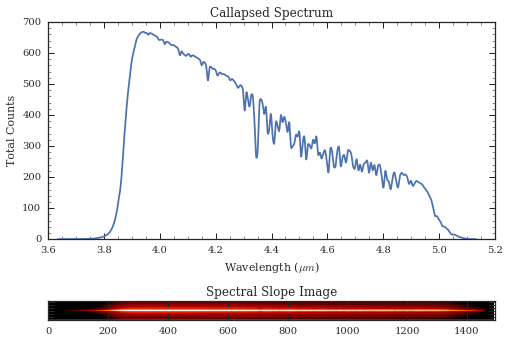

In [37]:
# For fun, plot the collapsed spectral image w.r.t. wavelength
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(7,1)
ax1 = plt.subplot(gs[:-2, :])
ax2 = plt.subplot(gs[-1, :])

# Collapsed spectrum
ax1.plot(w, im_slope.sum(axis=0))
ax1.set_ylabel('Total Counts')
ax1.set_xlabel('Wavelength ($\mu m$)')
ax1.set_title('Callapsed Spectrum')
ax1.minorticks_on()

# Show the 2D spectral image as well
vmin = 1e-2
vmax = im_slope.max()
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ax2.imshow(im_slope, norm=norm)
ax2.set_title('Spectral Slope Image')
ax2.set_yticklabels('');

In [66]:
# The resulting image size is only as large as the dispersed spectrum
# Expand image to larger size
xpix = nrc.det_info['xpix']
ypix = nrc.det_info['ypix']
im_slope = nrc_utils.pad_or_cut_to_size(im_slope, (ypix,xpix))
im_slope[im_slope==0] = im_slope[im_slope>0].min()

In [41]:
nrc.multiaccum.

{u'nd1': 0,
 u'nd2': 0,
 u'nd3': 0,
 u'nf': 1,
 u'ngroup': 349,
 u'nint': 76,
 u'read_mode': 'RAPID'}

In [ ]:
# Create a ramp from the slope image
def slope_to_ramp(im_slope, ngroup=2, nf=1, nd1=0, nd2=0, nd3=0, **kwargs):
    # Add Poisson noise at each frame step
    
    # Import noise generator and create dark ramp
    
    # Add two ramps together
    
    # Remove drops and average grouped data

In [4]:
# This defines all the necessary stuff for the telescope/instrument setup
# Filters, coronagraphy, detector readout, and MULTIACCUM ramp settings
# See SimNRC.inst_set() for more details
inst_params = {'filter': 'F322W2', 'mask': None, 'pupil': 'GRISM0', 'module': 'A',
               'xpix': 2048, 'ypix': 64, 'x0':0, 'y0':0, 
               'read_mode':'RAPID', 'wind_mode': 'STRIPE', 'cnaw_filt': False,
               'nramps': 76, 'ngroup': 349, 'nf': 1, 'nd1': 0, 'nd2': 0, 'nd3': 0}

# Create the telescope instance
Tel = SimNRC.TelSetup(inst_params)

In [5]:
print('Frame Time: %0.3f sec' % Tel.exp_times['frame_time'])
print('Group Time: %0.3f sec' % Tel.exp_times['grp_time'])
print('Ramp Time: %0.3f sec' % Tel.exp_times['ramp_time'])
print('Exposure Time: %0.3f sec' % Tel.exp_times['exp_time'])
print('')
print('Well Depth: %0.0f e-' % Tel.well_depth)
print('Pixel Scale: %0.4f arcsec/pix' % Tel.pix_scale)

#Tel.exp_times['ramp_time'] / ( Tel.exp_times['ramp_time'] + Tel.exp_times['frame_time'] )

Frame Time: 0.341 sec
Group Time: 0.341 sec
Ramp Time: 118.873 sec
Exposure Time: 9034.340 sec

Well Depth: 75000 e-
Pixel Scale: 0.0648 arcsec/pix


Average Wavelength: 3.356 microns
Bandpass Width: [2.763,3.949] 1.186 microns
2.79487948679


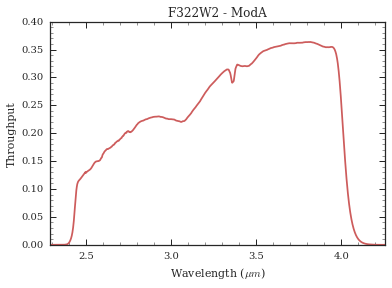

In [6]:
# Plot the Bandpass Filter Curve
ax = Tel.plot_bp();
ax.minorticks_on()

mid = Tel.bandpass.avgwave() / 1e4
width = Tel.bandpass.rectwidth() / 1e4
print('Average Wavelength: %.3f microns' % mid)
print('Bandpass Width: [%.3f,%.3f] %.3f microns' % (mid-width/2,mid+width/2,width))
print(Tel.bandpass.sample(3.7e4) / Tel.bandpass.sample(2.5e4))

In [7]:
# Generate PSF (such as coefficients) from WebbPSF
Tel.update_psfinfo()

In [8]:
# Saturation Limits assuming a G2V star
#Tel.update_sat_G2V(kband=False, quiet=False)

In [9]:
#Tel.update_bglim(quiet=False, nsig=5, units='uJy')

In [10]:
# Scene Setup - Source Positions and Fluxes
# Initialize Scene then add primary to center of scene
scene_params = {'offset_r': None, 'offset_ang': 0, 'image_PA': 0, 'zodi_level': 2}
Scene = SimNRC.SceneSetup(scene_params)

In [11]:
# WASP-39b transit
target = 'WASP-39'

# Source Spectra using Phoenix Models
sp = S.Icat('phoenix', 5400, -0.12, 4.44)
# Renormalize spectrum to 5.24 mags at K-Band
spA = sp.renorm(10.202, 'vegamag', S.ObsBandpass('johnson,k'))
spA.name = target # Specify target name/description
# Add spectral object to center of scene
Scene.addPointSource(spA)

In [12]:
# Useful parameters to pass to WebbPSF for generating simulations. 
webbpsf_params = {'nlambda': None, 'output_mode': 'detector sampled', 'rebin': True,
                  'calc_oversample': 4, 'detector_oversample': 2, 'oversample': 2,
                  'pupil_shift_x': 0, 'pupil_shift_y': 0, 'pupil_rot': 0,
                  'jitter': None, 'jitter_sigma': 0.007, 'opd_slice': 0}
Obs = SimNRC.Obs(Tel, Scene, webbpsf_params)

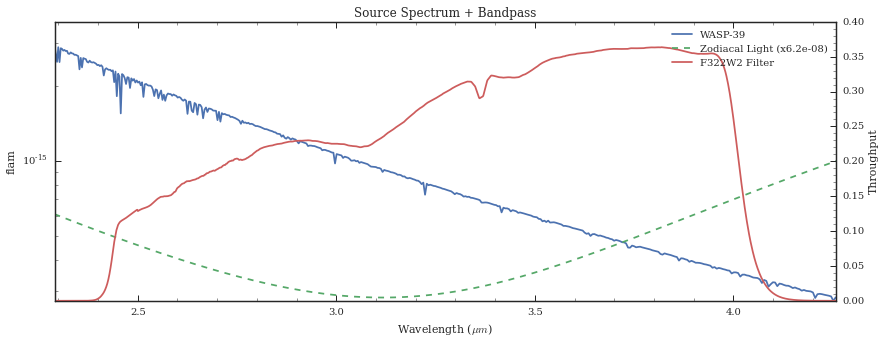

In [13]:
# Plot the source spectra overplotted with the instrument bandpass
Obs.plot_obs()

In [14]:
coeff = Tel.psf_info['coeff']

inst_params = Tel.inst_params
pupil = inst_params['pupil']
module = inst_params['module']

# Calculate exposure times 
exp_times = calc_exptime(inst_params)
tf = exp_times['frame_time']
n = inst_params['ngroup']
m = inst_params['nf']
nd2 = inst_params['nd2']
nramps = inst_params['nramps']

# Get filter throughput and create bandpass
bp = Tel.bandpass
waveset = np.copy(bp.wave)


# Detector specific stuff 
if bp.avgwave()/1e4 < 2.3:
    pix_scale = sw_pix_scl # pixel scale (arcsec/pixel)
    idark = 0.003          # dark current (e/sec)
    pex = [1.0,5.0]
else:
    pix_scale = lw_pix_scl
    idark = 0.03
    pex = [1.5,10.0]

# Zodiacal Light Stuff
sp_zodi = zodi_spec(Scene.scene_params['zodi_level'])
obs_zodi = S.Observation(sp_zodi, bp, binset=waveset)
fzodi_asec = obs_zodi.countrate() / (206265**2) # e-/sec/asec^2
fzodi_pix = fzodi_asec * pix_scale**2

# Object spectrum
sp = Scene.sources[0]['spectrum']

bp_norm = S.ObsBandpass('johnson,k')
bp_norm.name = 'K-Band'
mag_norm = 10.202
sp_norm = sp.renorm(mag_norm, 'vegamag', bp_norm)

In [16]:
# Set up an observation of the spectrum using the specified bandpass
# Use the bandpass wavelength set to bin the fluxes
obs = S.Observation(sp_norm, bp, binset=waveset)

# Convert observation to counts (e/sec)
obs.convert('counts')

# Set stellar flux
star_flux = obs.countrate() # e/sec

# Select which wavelengths to use
igood = bp_igood(bp)
wgood = (waveset)[igood] / 1e4
w1 = wgood.min()
w2 = wgood.max()
wrange = w2 - w1

# Photon flux per wavelength, taking into account all throughputs
fgood = (obs.binflux)[igood] 
nwave = wgood.size

In [17]:
# Create a PSF for each wgood wavelength
psf_fit = np.polynomial.polynomial.polyval(wgood, coeff)

# Multiply each PSF by fgood for the binned e/sec at each wavelength
psf_fit *= fgood # Array broadcasting: [nx,ny,nwave] x [0,0,nwave]

# The number of pixels to span spatially
fov_pix = 31; oversample = 3
fov_pix_over = fov_pix * oversample


In [18]:
# If grism spectroscopy
if (pupil is not None) and ('GRISM' in pupil):
    # If GRISM90 (along columns) rotate by 90 deg CW (270 deg CCW)
    if 'GRISM90' in pupil:
        psf_fit = np.rot90(psf_fit, k=3) # Rotate PSFs by 3*90 deg CCW

    # Mean spectral dispersion
    if ('GRISM90' in pupil) and (module == 'A'):
        res = 1003.12
    if ('GRISM0' in pupil) and (module == 'A'):
        res = 996.48
    if ('GRISM90' in pupil) and (module == 'B'):
        res = 1008.64
    if ('GRISM0' in pupil) and (module == 'B'):
        res = 1009.13
    # Spectral resolution in um/pixel
    dw = 1. / res

    # Number of real pixels that spectra will span
    npix_spec = wrange // dw + 1 + fov_pix
    npix_spec_over = npix_spec * oversample

    # Create oversampled spectral image
    spec_over = np.zeros([fov_pix_over, npix_spec_over])
    # Place each PSF at its dispersed location
    for i, w in enumerate(wgood):
        # Separate shift into an integer and fractional shift
        delx = oversample * (w-w1) / dw # Number of oversampled pixels to shift
        intx = int(delx)
        fracx = delx - intx
        if fracx < 0:
            fracx = fracx + 1
            intx = intx - 1

        im = psf_fit[:,:,i]
        spec_over[:,intx:intx+fov_pix_over] += im*(1.-fracx) + np.roll(im,1,axis=1)*fracx
        
    # Rebin ovesampled spectral image to real pixels
    spec = poppy.utils.krebin(spec_over, (fov_pix,npix_spec))

    # Wavelength solutions
    dw_over = dw/oversample
    w1_spec = w1 - dw_over*fov_pix_over/2
    wspec_over = np.arange(npix_spec_over)*dw_over + w1_spec
    wspec = wspec_over.reshape((npix_spec,-1)).mean(axis=1)

In [19]:
    # Wavelengths to grab sensitivity values
    igood2 = bp.throughput > (bp.throughput.max()/4)
    wgood2 = wspec
    wdel = 0.01*wgood2
    wgood2_min = wgood2 - wdel/2
    wgood2_max = wgood2 + wdel/2

    ind = 0; w2 = 0
    wsen_arr = []
    while (w2 < wgood2.max()):
        w = wgood2[ind]
        w1 = wgood2_min[ind]
        w2 = wgood2_max[ind]
        if w2 >= wgood2_min.max():
            break
        wsen_arr.append(w)
        ind = (np.where(wgood2_min >= w2))[0][0]
    wsen_arr = np.asarray(wsen_arr)
    #igood2 = bp.throughput > (bp.throughput.max()/4)
    #wgood2 = waveset[igood2] / 1e4
    #wsen_arr = np.unique((wgood2*10 + 0.5).astype('int')) / 10
    #wdel = wsen_arr[1] - wsen_arr[0]

    # Wavelength bins for spectral data
    wdel = 0.01*wsen_arr
    wsen1 = wsen_arr - wdel/2
    wsen2 = wsen_arr + wdel/2

    # Get spectral indices on the spectral image
    ispec1 = []
    ispec2 = []
    for i in np.arange(wsen_arr.size):
        ind = (np.where(wspec >= wsen1[i]))[0]
        ispec1.append(ind[0])
        ind = (np.where(wspec >= wsen2[i]))[0]
        ispec2.append(ind[0])
    ispec1 = np.asarray(ispec1)
    ispec2 = np.asarray(ispec2)
    ispec2[:-1] = ispec1[1:]


In [20]:
    # FWHM at each pixel position
    fwhm_pix_arr = np.ceil(wsen_arr * 0.206265 / 6.5 / pix_scale)
    # Make sure there's at least 5 total pixels in spatial dimension
    temp = fwhm_pix_arr.repeat(2).reshape([fwhm_pix_arr.size,2])
    temp[:,0] = 2
    rad_arr = temp.max(axis=1)
    # Doing a 5x2 [spatial x spectral] aperture
    #rad_arr[:] = 3

    # Spatial aperture size at each wavelength
    ap_spat = (2*rad_arr+1).astype('int')
    # Indices with spectral image
    ispat1 = (fov_pix - ap_spat) // 2
    ispat2 = ispat1 + ap_spat
    print(ap_spat)

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7]


In [21]:
    snr_arr = []
    for i in np.arange(wsen_arr.size):
        im = spec[ispat1[i]:ispat2[i],ispec1[i]:ispec2[i]]
        ns_im = pix_noise(n=n, m=m, s=nd2, tf=tf, rn=10, idark=idark, 
            fzodi=fzodi_pix, fsrc=im, p_excess=pex)
        im_sum = im.sum()
        ns_sum = np.sqrt(np.sum(ns_im**2) / nramps)
        snr_arr.append(im_sum / ns_sum)
    snr_arr = np.asarray(snr_arr)

In [23]:
#print(wsen_arr)
#print(np.sqrt((1.0/snr_arr)**2 + (3e-5)**2))
#print(1e6/snr_arr)

res = np.sqrt((1.0/snr_arr)**2 + (3e-5)**2)
res = 1.0 / snr_arr

# Create easily printable version
lim_arr = np.array([wsen_arr,res*np.sqrt(2)]).T
matrix = lim_arr.tolist()
s = [[str('{0:.2f}').format(e) for e in row] for row in matrix]
s = [[str('{0:.4f}').format(row[0]), str('{0:.6f}').format(row[1])] for row in matrix]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print('Wave\tLimit')
print('\n'.join(table))

Wave	Limit
2.3758	0.173773
2.3998	0.000763
2.4249	0.000236
2.4500	0.000139
2.4751	0.000126
2.5002	0.000120
2.5263	0.000119
2.5524	0.000118
2.5785	0.000116
2.6046	0.000113
2.6317	0.000111
2.6587	0.000111
2.6858	0.000109
2.7129	0.000106
2.7410	0.000105
2.7691	0.000106
2.7972	0.000105
2.8263	0.000103
2.8554	0.000103
2.8845	0.000104
2.9136	0.000104
2.9438	0.000105
2.9739	0.000107
3.0040	0.000110
3.0351	0.000110
3.0662	0.000112
3.0973	0.000110
3.1294	0.000109
3.1615	0.000108
3.1936	0.000108
3.2257	0.000104
3.2589	0.000103
3.2920	0.000103
3.3251	0.000101
3.3592	0.000105
3.3933	0.000104
3.4275	0.000103
3.4626	0.000104
3.4977	0.000103
3.5338	0.000103
3.5700	0.000103
3.6061	0.000104
3.6432	0.000104
3.6803	0.000105
3.7175	0.000105
3.7556	0.000107
3.7937	0.000109
3.8319	0.000108
3.8710	0.000111
3.9102	0.000111
3.9503	0.000114
3.9904	0.000128
4.0306	0.000192
4.0717	0.000400
4.1129	0.001115
